In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import os
import sys
import librosa
import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from IPython.display import Audio

import tensorflow as tf
import keras
from keras.callbacks import ReduceLROnPlateau
from keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout, BatchNormalization,Input,Conv2D,MaxPooling2D, InputLayer, UpSampling2D, Layer, Reshape
from keras.utils import np_utils, to_categorical
from keras.callbacks import ModelCheckpoint

import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning) 

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
!unzip "/content/drive/MyDrive/archive (2).zip" -d "ravdess"

Archive:  /content/drive/MyDrive/archive (2).zip
  inflating: ravdess/Actor_01/03-01-01-01-01-01-01.wav  
  inflating: ravdess/Actor_01/03-01-01-01-01-02-01.wav  
  inflating: ravdess/Actor_01/03-01-01-01-02-01-01.wav  
  inflating: ravdess/Actor_01/03-01-01-01-02-02-01.wav  
  inflating: ravdess/Actor_01/03-01-02-01-01-01-01.wav  
  inflating: ravdess/Actor_01/03-01-02-01-01-02-01.wav  
  inflating: ravdess/Actor_01/03-01-02-01-02-01-01.wav  
  inflating: ravdess/Actor_01/03-01-02-01-02-02-01.wav  
  inflating: ravdess/Actor_01/03-01-02-02-01-01-01.wav  
  inflating: ravdess/Actor_01/03-01-02-02-01-02-01.wav  
  inflating: ravdess/Actor_01/03-01-02-02-02-01-01.wav  
  inflating: ravdess/Actor_01/03-01-02-02-02-02-01.wav  
  inflating: ravdess/Actor_01/03-01-03-01-01-01-01.wav  
  inflating: ravdess/Actor_01/03-01-03-01-01-02-01.wav  
  inflating: ravdess/Actor_01/03-01-03-01-02-01-01.wav  
  inflating: ravdess/Actor_01/03-01-03-01-02-02-01.wav  
  inflating: ravdess/Actor_01/03-01-03-

In [5]:
import shutil
shutil.rmtree('/content/ravdess/audio_speech_actors_01-24', ignore_errors=True)


In [6]:
Ravdess="/content/ravdess"
ravdess_directory_list = os.listdir("/content/ravdess")

file_gender=[]
file_emotion = []
file_path = []
for dir in ravdess_directory_list:
    '''# as their are 20 different actors in our previous directory we need to extract files for each actor.'''
    directory=os.path.join(Ravdess, dir)
    actor = os.listdir(directory)
    for i,file in enumerate(actor):
        part = file.split('.')[0]
        part = part.split('-')
        
        '''# third part in each file represents the emotion associated to that file.'''
        file_emotion.append(int(part[2]))
        temp = int(part[6])
        if temp%2 == 0:
            temp = "female"
        else:
            temp = "male"
        file_gender.append(temp)
        file_path.append(Ravdess +'/'+ dir + '/' + file)
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])
emotion_df.replace({1:'neutral', 2:'calm', 3:'happy', 4:'sad', 5:'angry', 6:'fear', 7:'disgust', 8:'surprise'}, inplace=True)
gender=pd.DataFrame(file_gender,columns=['Gender'])
emotion_df=pd.concat([emotion_df,gender],axis=1)

'''# dataframe for path of files.'''
path_df = pd.DataFrame(file_path, columns=['Path'])
Ravdess_df = pd.concat([emotion_df, path_df], axis=1)
Ravdess_df['labels'] =Ravdess_df.Gender + '_' + Ravdess_df.Emotions
Ravdess_df=Ravdess_df.drop('Emotions',axis=1)
Ravdess_df=Ravdess_df.drop('Gender',axis=1)

'''# changing integers to actual emotions.'''

Ravdess_df.head()

,Path,labels
0,/content/ravdess/Actor_17/03-01-02-01-02-02-17...,male_calm
1,/content/ravdess/Actor_17/03-01-02-01-01-02-17...,male_calm
2,/content/ravdess/Actor_17/03-01-06-01-02-02-17...,male_fear
3,/content/ravdess/Actor_17/03-01-03-01-02-01-17...,male_happy
4,/content/ravdess/Actor_17/03-01-06-01-01-02-17...,male_fear


In [7]:
Ravdess_df['labels'].value_counts()



male_calm          96
male_fear          96
male_happy         96
male_angry         96
male_sad           96
male_surprise      96
male_disgust       96
female_fear        96
female_happy       96
female_angry       96
female_calm        96
female_surprise    96
female_disgust     96
female_sad         96
male_neutral       48
female_neutral     48
Name: labels, dtype: int64

In [8]:
def create_waveplot(data, sr, e):
    plt.figure(figsize=(10, 3))
    plt.title('Waveplot for audio with {} emotion'.format(e), size=15)
    librosa.display.waveshow(data, sr=sr)
    
    plt.show()

def create_spectrogram(data, sr, e):

    '''# stft function converts the data into short term fourier transform'''
    X = librosa.stft(data)
    Xdb = librosa.amplitude_to_db(abs(X))
    plt.figure(figsize=(12, 3))
    plt.title('Spectrogram for audio with {} emotion'.format(e), size=15)
    librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')   
  
    plt.colorbar()

/content/ravdess/Actor_22/03-01-05-02-02-02-22.wav


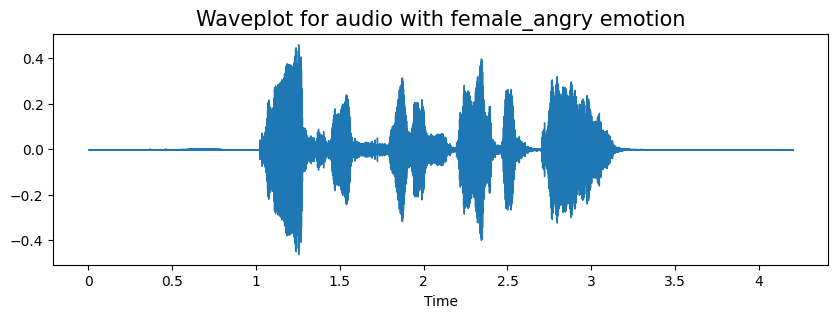

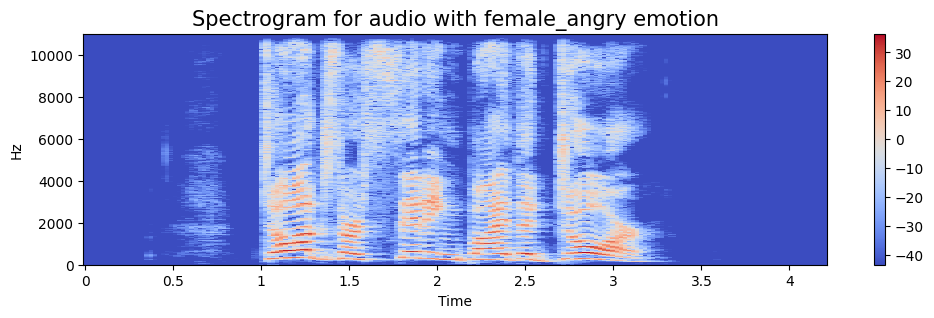

In [9]:
emotion='female_angry'
path = np.array(Ravdess_df.Path[Ravdess_df.labels==emotion])[1]
print(path)
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

/content/ravdess/Actor_17/03-01-05-02-02-02-17.wav


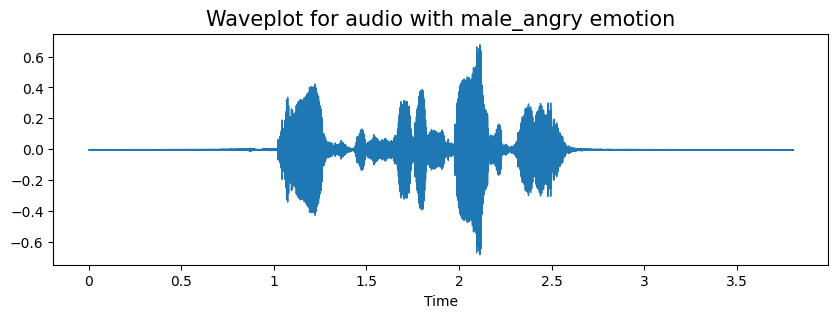

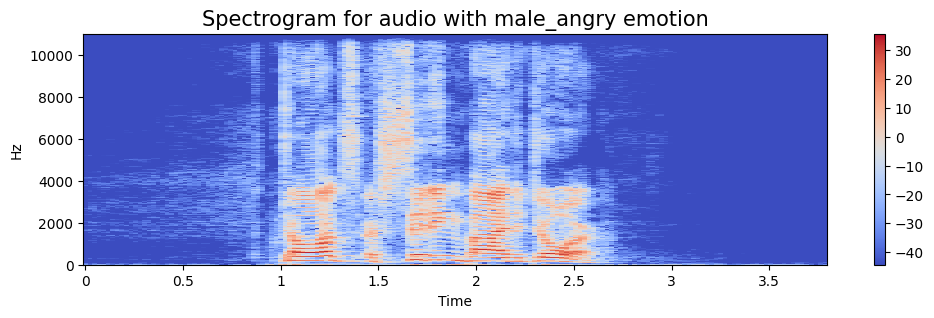

In [10]:
emotion='male_angry'
path = np.array(Ravdess_df.Path[Ravdess_df.labels==emotion])[1]
print(path)
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

In [11]:
def noise(data):
    noise_amp = 0.035*np.random.uniform()*np.amax(data)
    data = data + noise_amp*np.random.normal(size=data.shape[0])
    return data

def stretch(data, rate=0.8):
    return librosa.effects.time_stretch(data,rate= 0.8)

def shift(data):
    shift_range = int(np.random.uniform(low=-5, high = 5)*1000)
    return np.roll(data, shift_range)

def pitch(data, sampling_rate, pitch_factor=0.7):
    return librosa.effects.pitch_shift(data, sampling_rate, pitch_factor)

'''# taking any example and checking for techniques.'''

path = np.array(Ravdess_df.Path)[1]
data, sample_rate = librosa.load(path)



In [12]:
def extract_features(data):
    '''# ZCR'''
    result = np.array([])
    zcr = np.mean(librosa.feature.zero_crossing_rate(y=data).T, axis=0)
    result=np.hstack((result, zcr)) 

    '''# Chroma_stft'''
    stft = np.abs(librosa.stft(data))
    chroma_stft = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T, axis=0)
    result = np.hstack((result, chroma_stft)) 
    '''# MFCC'''
    mfcc = np.mean(librosa.feature.mfcc(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mfcc)) 

    '''# Root Mean Square Value'''
    rms = np.mean(librosa.feature.rms(y=data).T, axis=0)
    result = np.hstack((result, rms)) 

    '''# MelSpectogram'''
    mel = np.mean(librosa.feature.melspectrogram(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mel)) 
    
    return result
def get_features(path):

    '''# duration and offset are used to take care of the no audio in start and the ending of each audio files as seen above.'''
    data, sample_rate = librosa.load(path, duration=2.5, offset=0.6)
    
    '''# without augmentation'''
    res1 = extract_features(data)
    result = np.array(res1)
    
    '''# data with noise'''
    noise_data = noise(data)
    res2 = extract_features(noise_data)
    result = np.vstack((result, res2)) 
    
    '''# data with stretching and pitching'''
    
    res3 = extract_features(data)
    result = np.vstack((result, res3)) 
    
    return result

In [13]:
X, Y = [], []
for path, emotion in tqdm(zip(Ravdess_df.Path, Ravdess_df.labels)):
    feature = get_features(path)
    for ele in feature:
        X.append(ele)
        
        Y.append(emotion)

1440it [04:33,  5.27it/s]


In [14]:
len(X), len(Y), Ravdess_df.Path.shape

(4320, 4320, (1440,))

In [15]:
Features = pd.DataFrame(X)
Features['labels'] = Y
Features.to_csv('features.csv', index=False)
Features.head()

,0,1,2,3,4,5,6,7,8,9,...,153,154,155,156,157,158,159,160,161,labels
0,0.129978,0.661810,0.698865,0.677321,0.600539,0.603618,0.585204,0.560863,0.650525,0.655946,...,0.000168,0.000325,0.000289,0.000269,0.000442,0.000420,0.000330,0.000080,9.556467e-06,male_calm
1,0.227566,0.717570,0.754474,0.711292,0.670703,0.671903,0.611643,0.590560,0.661543,0.661820,...,0.000219,0.000373,0.000343,0.000315,0.000482,0.000469,0.000376,0.000135,5.766977e-05,male_calm
2,0.129978,0.661810,0.698865,0.677321,0.600539,0.603618,0.585204,0.560863,0.650525,0.655946,...,0.000168,0.000325,0.000289,0.000269,0.000442,0.000420,0.000330,0.000080,9.556467e-06,male_calm
3,0.112590,0.656797,0.718727,0.725443,0.646329,0.613962,0.650191,0.613595,0.574008,0.618592,...,0.000018,0.000026,0.000028,0.000022,0.000021,0.000016,0.000016,0.000010,7.881164e-07,male_calm
4,0.275083,0.740322,0.842331,0.823966,0.752015,0.752335,0.700227,0.644489,0.642047,0.677588,...,0.000107,0.000115,0.000118,0.000117,0.000111,0.000106,0.000112,0.000098,9.115175e-05,male_calm


In [16]:
X = Features.iloc[: ,:-1].values
Y = Features['labels'].values

In [17]:
encoder = OneHotEncoder()
Y = encoder.fit_transform(np.array(Y).reshape(-1,1)).toarray()

In [18]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, random_state=0, shuffle=True)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((3240, 162), (3240, 16), (1080, 162), (1080, 16))

In [19]:
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((3240, 162), (3240, 16), (1080, 162), (1080, 16))

In [20]:
'''# making our data compatible to model.'''

x_train = np.expand_dims(x_train, axis=2)
x_test = np.expand_dims(x_test, axis=2)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((3240, 162, 1), (3240, 16), (1080, 162, 1), (1080, 16))

***CNN***

In [21]:
model=Sequential()
model.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu', input_shape=(x_train.shape[1], 1)))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))
model.add(Conv1D(128, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))
model.add(Dropout(0.2))

model.add(Conv1D(64, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))
model.add(Flatten())
model.add(Dense(units=32, activation='relu'))
model.add(Dropout(0.3))

model.add(Dense(units=16, activation='softmax'))
model.compile(optimizer = 'adam' , loss = 'categorical_crossentropy' , metrics = ['accuracy'])

In [22]:
rlrp = ReduceLROnPlateau(monitor='loss', factor=0.4, verbose=0, patience=2, min_lr=0.0000001)
history=model.fit(x_train, y_train, batch_size=64, epochs=20, validation_data=(x_test, y_test), callbacks=[rlrp])

Epoch 1/20
51/51 [==============================] - 15s 41ms/step - loss: 2.6554 - accuracy: 0.1198 - val_loss: 2.5875 - val_accuracy: 0.1444 - lr: 0.0010
Epoch 2/20
51/51 [==============================] - 1s 21ms/step - loss: 2.5111 - accuracy: 0.1571 - val_loss: 2.4075 - val_accuracy: 0.1778 - lr: 0.0010
Epoch 3/20
51/51 [==============================] - 1s 16ms/step - loss: 2.3886 - accuracy: 0.1849 - val_loss: 2.3002 - val_accuracy: 0.2056 - lr: 0.0010
Epoch 4/20
51/51 [==============================] - 1s 15ms/step - loss: 2.2675 - accuracy: 0.2068 - val_loss: 2.1050 - val_accuracy: 0.2935 - lr: 0.0010
Epoch 5/20
51/51 [==============================] - 1s 15ms/step - loss: 2.1211 - accuracy: 0.2451 - val_loss: 2.0578 - val_accuracy: 0.2889 - lr: 0.0010
Epoch 6/20
51/51 [==============================] - 1s 25ms/step - loss: 2.0528 - accuracy: 0.2623 - val_loss: 1.9477 - val_accuracy: 0.3287 - lr: 0.0010
Epoch 7/20
51/51 [==============================] - 1s 21ms/step - loss: 1.

In [ ]:
'''# Save model and weights'''

model_name = 'Emotion_Model.h5'
save_dir = os.path.join(os.getcwd(), 'saved_models')

if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
model_path = os.path.join(save_dir, model_name)
model.save(model_path)
print('Save model and weights at %s ' % model_path)

'''# Save the model to disk'''

model_json = model.to_json()
with open("model_json.json", "w") as json_file:
    json_file.write(model_json)

Save model and weights at /content/saved_models/Emotion_Model.h5 


34/34 [==============================] - 3s 93ms/step - loss: 0.7333 - accuracy: 0.7741
Accuracy of our model on test data :  77.40740776062012 %


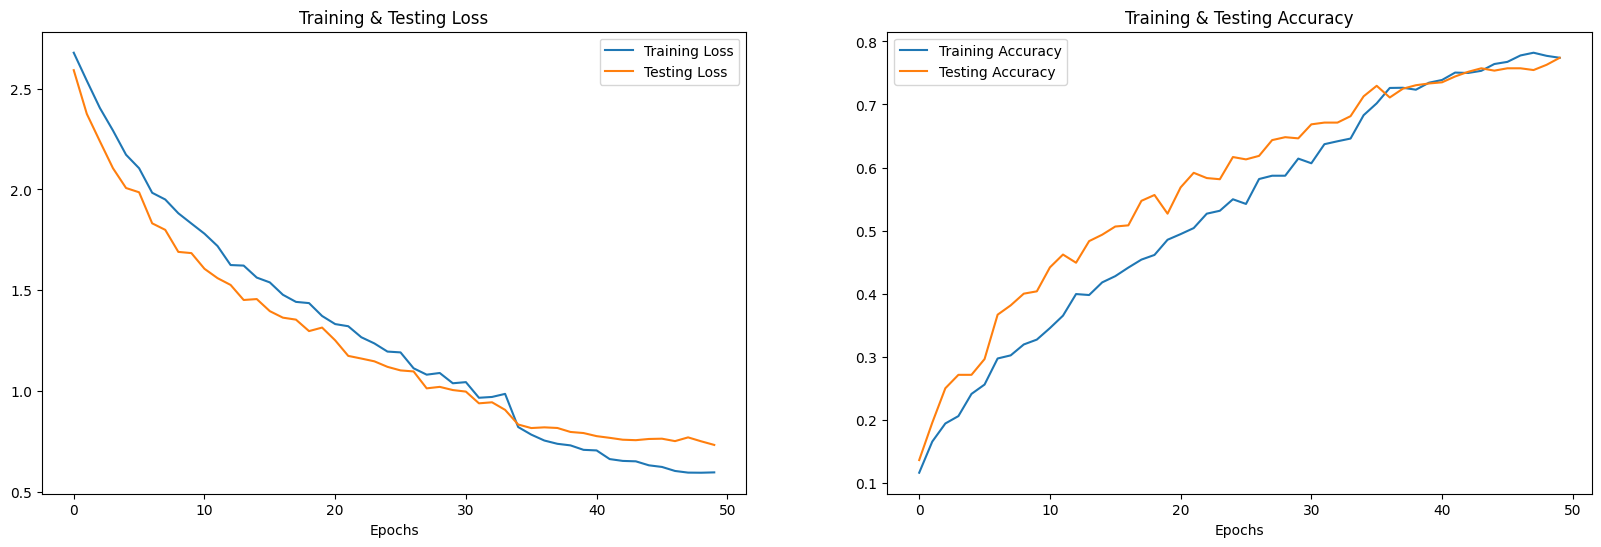

In [ ]:
print("Accuracy of our model on test data : " , model.evaluate(x_test,y_test)[1]*100 , "%")

epochs = [i for i in range(50)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
test_acc = history.history['val_accuracy']
test_loss = history.history['val_loss']

fig.set_size_inches(20,6)
ax[0].plot(epochs , train_loss , label = 'Training Loss')
ax[0].plot(epochs , test_loss , label = 'Testing Loss')
ax[0].set_title('Training & Testing Loss')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[1].plot(epochs , train_acc , label = 'Training Accuracy')
ax[1].plot(epochs , test_acc , label = 'Testing Accuracy')
ax[1].set_title('Training & Testing Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")
plt.show()

In [ ]:
'''# predicting on test data.'''

pred_test = model.predict(x_test)
y_pred = encoder.inverse_transform(pred_test)

y_test = encoder.inverse_transform(y_test)

34/34 [==============================] - 2s 46ms/step


In [ ]:
df = pd.DataFrame(columns=['Predicted Labels', 'Actual Labels'])
df['Predicted Labels'] = y_pred.flatten()
df['Actual Labels'] = y_test.flatten()

df.head(10)

,Predicted Labels,Actual Labels
0,female_disgust,female_disgust
1,female_sad,female_disgust
2,female_angry,female_disgust
3,female_angry,female_angry
4,female_disgust,female_disgust
5,female_happy,female_happy
6,male_surprise,male_happy
7,female_happy,female_happy
8,male_fear,male_fear
9,male_sad,male_sad


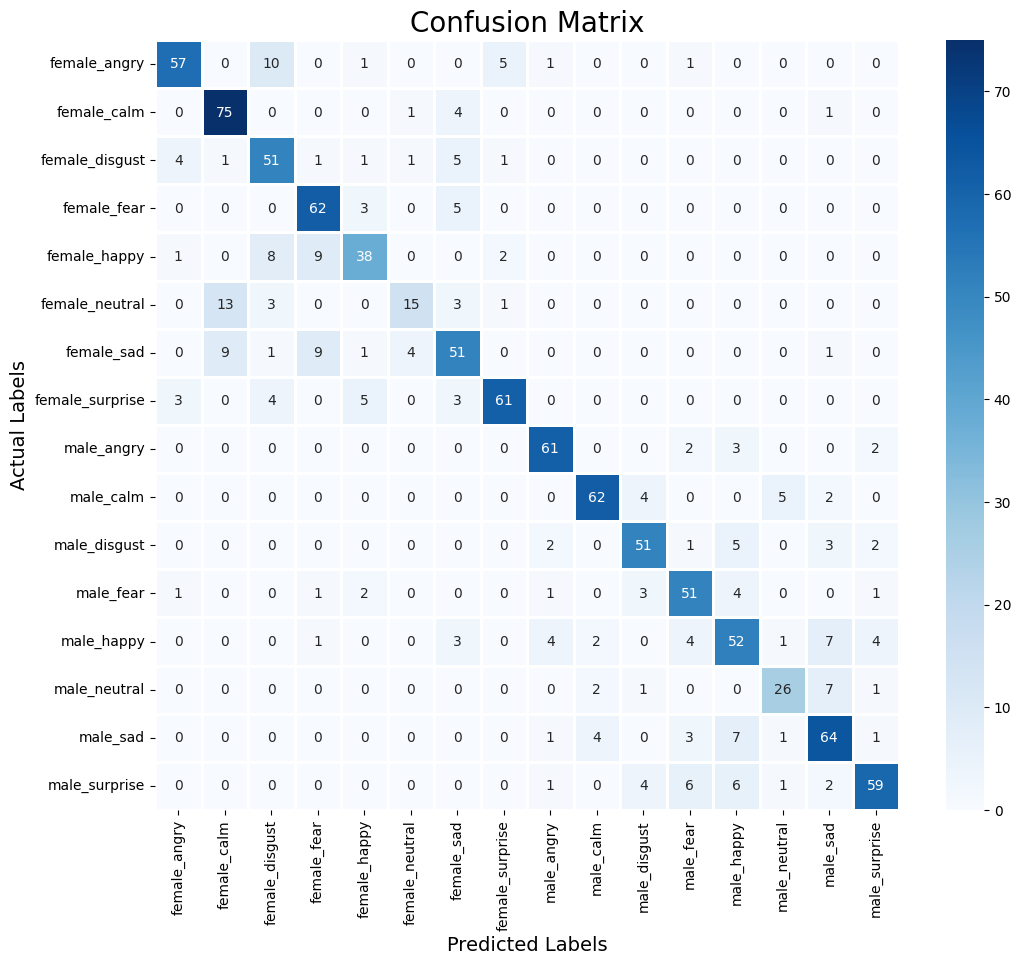

In [ ]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize = (12, 10))
cm = pd.DataFrame(cm , index = [i for i in encoder.categories_] , columns = [i for i in encoder.categories_])
sns.heatmap(cm, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='')
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.show()

In [ ]:
print(classification_report(y_test, y_pred))

                 precision    recall  f1-score   support

   female_angry       0.86      0.76      0.81        75
    female_calm       0.77      0.93      0.84        81
 female_disgust       0.66      0.78      0.72        65
    female_fear       0.75      0.89      0.81        70
   female_happy       0.75      0.66      0.70        58
 female_neutral       0.71      0.43      0.54        35
     female_sad       0.69      0.67      0.68        76
female_surprise       0.87      0.80      0.84        76
     male_angry       0.86      0.90      0.88        68
      male_calm       0.89      0.85      0.87        73
   male_disgust       0.81      0.80      0.80        64
      male_fear       0.75      0.80      0.77        64
     male_happy       0.68      0.67      0.67        78
   male_neutral       0.76      0.70      0.73        37
       male_sad       0.74      0.79      0.76        81
  male_surprise       0.84      0.75      0.79        79

       accuracy              

In [24]:
!pip install keras-self-attention

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for keras-self-attention: filename=keras_self_attention-0.51.0-py3-none-any.whl size=18895 sha256=854e161dd3ab980892e2659924696713215a148b5f7b6301ed42584695bb4c42
  Stored in directory: /root/.cache/pip/wheels/b8/f7/24/607b483144fb9c47b4ba2c5fba6b68e54aeee2d5bf6c05302e
Successfully built keras-self-attention


Self-supervised

In [ ]:
pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 30.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 30.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.1/200.1 kB 24.8 MB/s eta 0:00:00


In [ ]:
pip install datasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 468.7/468.7 kB 12.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.2/212.2 kB 19.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 13.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.9/132.9 kB 14.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 45.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.2/114.2 kB 5.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 264.6/264.6 kB 29.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.8/158.8 kB 21.4 MB/s eta 0:00:00


In [ ]:
label_map = {'female_angry': 0, 'female_calm': 1, 'female_disgust': 2, 'female_fear': 3,'female_happy':4,'female_neutral':5,'female_sad':6,'female_surprise':7,'male_angry':8,'male_calm':9,'male_disgust':10,'male_fear':11,'male_happy':12,'male_neutral':13,'male_sad':14,'male_surprise':15}
Ravdess_df['labels'] = Ravdess_df['labels'].map(label_map)

In [ ]:
train_df = Ravdess_df.sample(frac=0.8)
test_df = Ravdess_df.drop(train_df.index)

In [ ]:
from transformers import Wav2Vec2FeatureExtractor
from datasets import Dataset

def map_to_array(example):
    speech, _ = librosa.load(example["Path"], sr=16000, mono=True)
    example["speech"] = speech
    return example

train_data = Dataset.from_pandas(train_df).map(map_to_array)
test_data = Dataset.from_pandas(test_df).map(map_to_array)

feature_extractor = Wav2Vec2FeatureExtractor.from_pretrained("superb/hubert-large-superb-er")

train_encodings = feature_extractor(list(train_data["speech"]), sampling_rate=16000, padding=True, return_tensors="pt")
test_encodings = feature_extractor(list(test_data["speech"]), sampling_rate=16000, padding=True, return_tensors="pt")

Map:   0%|          | 0/1152 [00:00<?, ? examples/s]

Map:   0%|          | 0/288 [00:00<?, ? examples/s]

In [ ]:
print(train_data[1])

{'Path': '/content/ravdess/Actor_03/03-01-06-02-02-02-03.wav', 'labels': 11, '__index_level_0__': 1147, 'speech': [-0.0013831183314323425, -0.003884304314851761, -0.0032573509961366653, -0.0021926239132881165, -0.0033830967731773853, -0.003083206247538328, -0.0018198168836534023, -0.0020194808021187782, -0.0017753072315827012, -0.0004771370440721512, -0.0011080908589065075, -0.0006866063922643661, -0.0006805071607232094, -0.0006051547825336456, -0.00047570839524269104, 0.00039451103657484055, 0.0009423000738024712, 0.001103729591704905, 0.0017840235959738493, 0.002312300493940711, 0.0026899869553744793, 0.0026812469586730003, 0.003346143290400505, 0.00296991690993309, 0.002951250411570072, 0.003307454288005829, 0.003316819667816162, 0.002943827770650387, 0.003345329314470291, 0.0029741248581558466, 0.003272762754932046, 0.003105303505435586, 0.003150728065520525, 0.003465433605015278, 0.0026441775262355804, 0.0025586821138858795, 0.0026914486661553383, 0.0022546499967575073, 0.00230782

In [ ]:
import torch

In [ ]:
class EmotionDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        pattern = {0:0, 1:1, 2:2, 3:3, 4:4,5:5,6:6,7:7,8:8,9:9,10:10,11:11,12:12,13:13,14:14,15:15}
        self.labels = [pattern[x] for x in labels]

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)
    

train_dataset = EmotionDataset(train_encodings, list(train_data["labels"]))
test_dataset = EmotionDataset(test_encodings, list(test_data["labels"]))

In [ ]:
from transformers import HubertForSequenceClassification,HubertConfig
from torch.optim import AdamW

'''# Loading the model'''
model = HubertForSequenceClassification.from_pretrained("facebook/hubert-large-ls960-ft")
config = model.config
config.num_labels = 16
new_model = HubertForSequenceClassification(config).cuda()

'''# Loading the optimizer'''
optim = AdamW(new_model.parameters(), lr=1e-3)

Some weights of the model checkpoint at facebook/hubert-large-ls960-ft were not used when initializing HubertForSequenceClassification: ['lm_head.bias', 'lm_head.weight']
- This IS expected if you are initializing HubertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing HubertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of HubertForSequenceClassification were not initialized from the model checkpoint at facebook/hubert-large-ls960-ft and are newly initialized: ['projector.bias', 'projector.weight', 'classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions a

In [ ]:
for param in new_model.parameters():
    param.requires_grad = False
      
layers_freeze_num = 2
n_layers = (
    4 + layers_freeze_num * 16)
for name, param in list(new_model.named_parameters())[-n_layers:]:
    param.requires_grad = True

In [ ]:
'''# Prediction function'''

def predict(outputs):
    probabilities = torch.softmax(outputs["logits"], dim=1)
    
    predictions = torch.argmax(probabilities, dim=1)
    return predictions

In [ ]:
'''# Training'''

from torch.utils.data import DataLoader

'''# Set the number of epoch'''
epoch = 50

'''# Start training'''

model.train()
train_loss = list()
train_accuracies = list()
for epoch_i in range(epoch):
    print('Epoch %s/%s' % (epoch_i + 1, epoch))
    
    '''# Get training data by DataLoader'''
    train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
    
    correct = 0
    count = 0
    epoch_loss = list()
    
    pbar = tqdm(train_loader)
    for batch in pbar:
        optim.zero_grad()
        input_ids = batch['input_values'].cuda()
        attention_mask = batch['attention_mask'].cuda()
        labels = batch['labels'].cuda()
        
        outputs = new_model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs['loss']
        loss.backward()
        optim.step()
        
        '''# make predictions'''
        predictions = predict(outputs)
        
        '''# count accuracy'''
        correct += predictions.eq(labels).sum().item()
        count += len(labels)
        accuracy = correct * 1.0 / count
        
        '''# show progress along with metrics
        # record the loss for each batch'''

        epoch_loss.append(loss.item())
    '''# record the loss and accuracy for each epoch'''

    train_loss += epoch_loss
    print(accuracy)
    train_accuracies.append(accuracy)

Epoch 1/50


100%|██████████| 144/144 [02:29<00:00,  1.04s/it]


0.0685763888888889
Epoch 2/50


100%|██████████| 144/144 [02:30<00:00,  1.04s/it]


0.0842013888888889
Epoch 3/50


100%|██████████| 144/144 [02:31<00:00,  1.05s/it]


0.08940972222222222
Epoch 4/50


100%|██████████| 144/144 [02:30<00:00,  1.04s/it]


0.10850694444444445
Epoch 5/50


100%|██████████| 144/144 [02:29<00:00,  1.04s/it]


0.109375
Epoch 6/50


100%|██████████| 144/144 [02:30<00:00,  1.04s/it]


0.11805555555555555
Epoch 7/50


100%|██████████| 144/144 [02:29<00:00,  1.04s/it]


0.1189236111111111
Epoch 8/50


100%|██████████| 144/144 [02:30<00:00,  1.05s/it]


0.1310763888888889
Epoch 9/50


100%|██████████| 144/144 [02:29<00:00,  1.04s/it]


0.13020833333333334
Epoch 10/50


100%|██████████| 144/144 [02:29<00:00,  1.04s/it]


0.13802083333333334
Epoch 11/50


100%|██████████| 144/144 [02:30<00:00,  1.04s/it]


0.12586805555555555
Epoch 12/50


100%|██████████| 144/144 [02:30<00:00,  1.05s/it]


0.1484375
Epoch 13/50


100%|██████████| 144/144 [02:28<00:00,  1.03s/it]


0.1328125
Epoch 14/50


100%|██████████| 144/144 [02:29<00:00,  1.04s/it]


0.1423611111111111
Epoch 15/50


100%|██████████| 144/144 [02:31<00:00,  1.05s/it]


0.14756944444444445
Epoch 16/50


100%|██████████| 144/144 [02:29<00:00,  1.04s/it]


0.12760416666666666
Epoch 17/50


100%|██████████| 144/144 [02:29<00:00,  1.04s/it]


0.1501736111111111
Epoch 18/50


100%|██████████| 144/144 [02:29<00:00,  1.04s/it]


0.15711805555555555
Epoch 19/50


100%|██████████| 144/144 [02:30<00:00,  1.05s/it]


0.1545138888888889
Epoch 20/50


100%|██████████| 144/144 [02:29<00:00,  1.04s/it]


0.15364583333333334
Epoch 21/50


100%|██████████| 144/144 [02:28<00:00,  1.03s/it]


0.1484375
Epoch 22/50


100%|██████████| 144/144 [02:29<00:00,  1.04s/it]


0.14149305555555555
Epoch 23/50


100%|██████████| 144/144 [02:29<00:00,  1.04s/it]


0.1527777777777778
Epoch 24/50


100%|██████████| 144/144 [02:31<00:00,  1.05s/it]


0.1527777777777778
Epoch 25/50


100%|██████████| 144/144 [02:29<00:00,  1.04s/it]


0.15885416666666666
Epoch 26/50


100%|██████████| 144/144 [02:30<00:00,  1.05s/it]


0.1623263888888889
Epoch 27/50


100%|██████████| 144/144 [02:29<00:00,  1.04s/it]


0.1736111111111111
Epoch 28/50


100%|██████████| 144/144 [02:31<00:00,  1.05s/it]


0.171875
Epoch 29/50


100%|██████████| 144/144 [02:29<00:00,  1.04s/it]


0.16319444444444445
Epoch 30/50


100%|██████████| 144/144 [02:30<00:00,  1.04s/it]


0.15538194444444445
Epoch 31/50


100%|██████████| 144/144 [02:30<00:00,  1.04s/it]


0.1675347222222222
Epoch 32/50


 93%|█████████▎| 134/144 [02:19<00:10,  1.06s/it]

In [ ]:
 print(train_accuracies)

[0.05642361111111111]


CNN-Pytorch

In [35]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os, glob
import librosa
import librosa.display
import IPython
from IPython.display import Audio
from IPython.display import Image
import warnings; warnings.filterwarnings('ignore')

In [36]:
def noise(data):
    noise_amp = 0.035*np.random.uniform()*np.amax(data)
    data = data + noise_amp*np.random.normal(size=data.shape[0])
    return data

def stretch(data, rate=0.8):
    return librosa.effects.time_stretch(data,rate= 0.8)

def shift(data):
    shift_range = int(np.random.uniform(low=-5, high = 5)*1000)
    return np.roll(data, shift_range)

In [37]:
sample_rate = 48000
def feature_mfcc(
    waveform, 
    sample_rate,
    n_mfcc = 40,
    fft = 1024,
    winlen = 512,
    window='hamming',
    mels=128
    ):
  
    '''# Compute the MFCCs for all STFT frames 
    # 40 mel filterbanks (n_mfcc) = 40 coefficients'''

    mfc_coefficients=librosa.feature.mfcc(
        y=waveform, 
        sr=sample_rate, 
        n_mfcc=n_mfcc,
        n_fft=fft, 
        win_length=winlen, 
        window=window, 
        n_mels=mels, 
        fmax=sample_rate/2
        ) 
    
    return mfc_coefficients

def get_features(waveforms, features, samplerate):

    '''# initialize counter to track progress'''
    file_count = 0

    '''# process each waveform individually to get its MFCCs'''
    for waveform in waveforms:
        
        mfccs = feature_mfcc(waveform, sample_rate)
        
        features.append(mfccs)
        file_count += 1
        
        '''# print progress''' 

        print('\r'+f' Processed {file_count}/{len(waveforms)} waveforms',end='')
    
    '''# return all features from list of waveforms'''
    return features

def get_waveforms(file):
    
    '''# load an individual sample audio file
    # read the full 3 seconds of the file, cut off the first 0.5s of silence; native sample rate = 48k
    # don't need to store the sample rate that librosa.load returns'''
    
    waveform, _ = librosa.load(file, duration=3, offset=0.5, sr=sample_rate)
    waveform=noise(waveform)
    # waveform=stretch(waveform)
    waveform=shift(waveform)
    waveform_homo = np.zeros((int(sample_rate*3,)))
    waveform_homo[:len(waveform)] = waveform
    
    '''# return a single file's waveform'''                                      
    return waveform_homo
    

In [38]:
emotions_dict ={
    '0':'surprised',
    '1':'neutral',
    '2':'calm',
    '3':'happy',
    '4':'sad',
    '5':'angry',
    '6':'fearful',
    '7':'disgust'
}

'''# Additional attributes from RAVDESS to play with'''

emotion_attributes = {
    '01': 'normal',
    '02': 'strong'
}

In [39]:
Ravdess="/content/ravdess"
ravdess_directory_list = os.listdir("/content/ravdess")
def load_data():
    '''# features and labels'''

    emotions = []

    '''# raw waveforms to augment later'''
    waveforms = []

    '''# extra labels'''
    intensities = []

    '''# progress counter'''
    file_count = 0

    for dir in ravdess_directory_list:
      directory=os.path.join(Ravdess, dir)
      actor = os.listdir(directory)
      for file_name in actor:
        try:
            file_path=Ravdess +'/'+ dir + '/' + file_name
            
            '''# get file name with labels'''
            part = file_name.split('.')[0]
            
            '''# get emotion label from the sample's file'''
            emotion = int(file_name.split("-")[2])
            
            '''#  move surprise to 0 for cleaner behaviour with PyTorch/0-indexing'''
            if emotion == 8: emotion = 0 # surprise is now at 0 index; other emotion indeces unchanged

            '''# can convert emotion label to emotion string if desired, but
            # training on number is better; better convert to emotion string after predictions are ready'''
            emotion = emotions_dict[str(emotion)]
            
            '''# get other labels we might want'''
            intensity = emotion_attributes[file_name.split("-")[3]]
            
            '''# even actors are female, odd are male'''          
            if (int((file_name.split("-")[6]).split(".")[0]))%2==0: 
                gender = 'female' 
            else: 
                gender = 'male'
                
            '''# get waveform from the sample'''
            waveform = get_waveforms(file_path)
            
            '''# store waveforms and labels'''
            waveforms.append(waveform)
            emotions.append(emotion)
            intensities.append(intensity) # store intensity in case we wish to predict
            genders.append(gender) # store gender in case we wish to predict 
            
            file_count += 1
            
            '''# keep track of data loader's progress'''
            print('\r'+f' Processed {file_count}/{1440} audio samples',end='')
        except:
          continue
            
    return waveforms, emotions, intensities, genders

Mounted at /content/drive


In [ ]:
waveforms, emotions, intensities, genders = [],[],[],[]
waveforms, emotions, intensities, genders = load_data()

In [ ]:
train_set,valid_set,test_set = [],[],[]
X_train,X_valid,X_test = [],[],[]
y_train,y_valid,y_test = [],[],[]


In [ ]:
waveforms = np.array(waveforms)


In [ ]:
print(emotions)

In [ ]:
for i,emotion_value in enumerate(emotions_dict.values()):
    
    '''# find all indices of a single unique emotion'''
    
    emotion_indices = [index for index, emotion in enumerate(emotions) if str(emotion)==str(emotion_value)]
    
    '''# seed for reproducibility''' 
    np.random.seed(69)

    '''# shuffle indicies'''
    emotion_indices = np.random.permutation(emotion_indices)
    
    '''# store dim (length) of the emotion list to make indices'''
    dim = len(emotion_indices)

    '''# store indices of training, validation and test sets in 80/10/10 proportion
    # train set is first 80%'''
    train_indices = emotion_indices[:int(0.8*dim)]
    
    '''# validation set is next 10% (between 80% and 90%)'''
    valid_indices = emotion_indices[int(0.8*dim):int(0.9*dim)]
    
    '''# test set is last 10% (between 90% - end/100%)'''
    test_indices = emotion_indices[int(0.9*dim):]
    X_train.append(waveforms[train_indices,:])
    x=np.full((len(train_indices),), i,dtype=np.float32)
    y_train.append(x)

    '''# create validation waveforms/labels sets'''
    X_valid.append(waveforms[valid_indices,:])
    y=x=np.full((len(test_indices),), i,dtype=np.float32)
    y_valid.append(y)
    
    '''# create test waveforms/labels sets'''
    X_test.append(waveforms[test_indices,:])
    z=x=np.full((len(test_indices),), i,dtype=np.float32)
    y_test.append(z)

    '''# store indices for each emotion set to verify uniqueness between sets''' 
    train_set.append(train_indices)
    valid_set.append(valid_indices)
    test_set.append(test_indices)

In [ ]:
X_train = np.concatenate(X_train,axis=0)
X_valid = np.concatenate(X_valid,axis=0)
X_test = np.concatenate(X_test,axis=0)

'''# concatenate, in order, all emotions back into one array'''
y_train = np.concatenate(y_train,axis=0)
y_valid = np.concatenate(y_valid,axis=0)
y_test = np.concatenate(y_test,axis=0)

In [ ]:
train_set = np.concatenate(train_set,axis=0)
valid_set = np.concatenate(valid_set,axis=0)
test_set = np.concatenate(test_set,axis=0)

In [ ]:
features_train, features_valid, features_test = [],[],[]

print('Train waveforms:') # get training set features 
features_train = get_features(X_train, features_train, sample_rate)

print('\n\nValidation waveforms:') # get validation set features
features_valid = get_features(X_valid, features_valid, sample_rate)

print('\n\nTest waveforms:') # get test set features 
features_test = get_features(X_test, features_test, sample_rate)

print(f'\n\nFeatures set: {len(features_train)+len(features_test)+len(features_valid)} total, {len(features_train)} train, {len(features_valid)} validation, {len(features_test)} test samples')
print(f'Features (MFC coefficient matrix) shape: {len(features_train[0])} mel frequency coefficients x {len(features_train[0][1])} time steps')

Train waveforms:
 Processed 1147/1147 waveforms

Validation waveforms:
 Processed 143/143 waveforms

Test waveforms:
 Processed 150/150 waveforms

Features set: 1440 total, 1147 train, 143 validation, 150 test samples
Features (MFC coefficient matrix) shape: 40 mel frequency coefficients x 282 time steps


In [ ]:
X_train = np.expand_dims(features_train,1)
X_valid = np.expand_dims(features_valid, 1)
X_test = np.expand_dims(features_test,1)

'''# convert emotion labels from list back to numpy arrays for PyTorch to work with '''
y_train = np.array(y_train)
y_valid = np.array(y_valid)
y_test = np.array(y_test)

In [ ]:
del features_train, features_valid, features_test, waveforms

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

'''#### Scale the training data ####
# store shape so we can transform it back'''
N,C,H,W = X_train.shape

'''# Reshape to 1D because StandardScaler operates on a 1D array
# tell numpy to infer shape of 1D array with '-1' argument'''
X_train = np.reshape(X_train, (N,-1)) 
X_train = scaler.fit_transform(X_train)

'''# Transform back to NxCxHxW 4D tensor format'''
X_train = np.reshape(X_train, (N,C,H,W))

'''##### Scale the validation set ####'''
N,C,H,W = X_valid.shape
X_valid = np.reshape(X_valid, (N,-1))
X_valid = scaler.transform(X_valid)
X_valid = np.reshape(X_valid, (N,C,H,W))

'''#### Scale the test set ####'''
N,C,H,W = X_test.shape
X_test = np.reshape(X_test, (N,-1))
X_test = scaler.transform(X_test)
X_test = np.reshape(X_test, (N,C,H,W))

In [34]:
class CNN(nn.Module):
    '''# Define all layers present in the network'''
    def __init__(self,num_emotions):
        super().__init__() 
        
        

        '''############### 1ST PARALLEL 2D CONVOLUTION BLOCK ############
        # 3 sequential conv2D layers: (1,40,282) --> (16, 20, 141) -> (32, 5, 35) -> (64, 1, 8)'''
        self.conv2Dblock1 = nn.Sequential(
            
            #'''# 1st 2D convolution layer'''
            nn.Conv2d(
                in_channels=1, # input volume depth == input channel dim == 1
                out_channels=16, # expand output feature map volume's depth to 16
                kernel_size=3, # typical 3*3 stride 1 kernel
                stride=1,
                padding=1
                      ),
            nn.BatchNorm2d(16), # batch normalize the output feature map before activation
            nn.ReLU(), # feature map --> activation map
            nn.MaxPool2d(kernel_size=2, stride=2), #typical maxpool kernel size
            nn.Dropout(p=0.3), #randomly zero 30% of 1st layer's output feature map in training
             
             #''# 2nd 2D convolution layer identical to last except output dim, maxpool kernel'''
            nn.Conv2d(
                in_channels=16, 
                out_channels=32, # expand output feature map volume's depth to 32
                kernel_size=3,
                stride=1,
                padding=1
                      ),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=4, stride=4), # increase maxpool kernel for subsequent filters
            nn.Dropout(p=0.3), 
            
            #'''# 3rd 2D convolution layer identical to last except output dim'''
            nn.Conv2d(
                in_channels=32,
                out_channels=64, # expand output feature map volume's depth to 64
                kernel_size=3,
                stride=1,
                padding=1
                      ),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=4, stride=4),
            nn.Dropout(p=0.3),)
        
        '''############### 2ND PARALLEL 2D CONVOLUTION BLOCK ############
        # 3 sequential conv2D layers: (1,40,282) --> (16, 20, 141) -> (32, 5, 35) -> (64, 1, 8)'''
        self.conv2Dblock2 = nn.Sequential(
            
            #'''# 1st 2D convolution layer'''
            nn.Conv2d(
                in_channels=1, # input volume depth == input channel dim == 1
                out_channels=16, # expand output feature map volume's depth to 16
                kernel_size=3, # typical 3*3 stride 1 kernel
                stride=1,
                padding=1
                      ),
            nn.BatchNorm2d(16), # batch normalize the output feature map before activation
            nn.ReLU(), # feature map --> activation map
            nn.MaxPool2d(kernel_size=2, stride=2), #typical maxpool kernel size
            nn.Dropout(p=0.3), #randomly zero 30% of 1st layer's output feature map in training
             
             
            nn.Conv2d(
                in_channels=16, 
                out_channels=32, # expand output feature map volume's depth to 32
                kernel_size=3,
                stride=1,
                padding=1
                      ),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=4, stride=4), # increase maxpool kernel for subsequent filters
            nn.Dropout(p=0.3), 
            
            #'''# 3rd 2D convolution layer identical to last except output dim'''
            nn.Conv2d(
                in_channels=32,
                out_channels=64, # expand output feature map volume's depth to 64
                kernel_size=3,
                stride=1,
                padding=1
                      ),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=4, stride=4),
            nn.Dropout(p=0.3),
        )
        self.fc1_linear = nn.Linear(512*2+40,num_emotions) 
        
        '''### Softmax layer for the 8 output logits from final FC linear layer '''
        self.softmax_out = nn.Softmax(dim=1) # dim==1 is the freq embedding
    def forward(self,x):
        
        '''############ 1st parallel Conv2D block: 4 Convolutional layers ############################
        # create final feature embedding from 1st convolutional layer'''

        '''# input features pased through 4 sequential 2D convolutional layers'''
        conv2d_embedding1 = self.conv2Dblock1(x) # x == N/batch * channel * freq * time
        
        '''# flatten final 64*1*4 feature map from convolutional layers to length 256 1D array 
        # skip the 1st (N/batch) dimension when flattening'''
        conv2d_embedding1 = torch.flatten(conv2d_embedding1, start_dim=1) 
        
        '''############ 2nd parallel Conv2D block: 4 Convolutional layers #############################
        # create final feature embedding from 2nd convolutional layer 
        # input features pased through 4 sequential 2D convolutional layers'''
        conv2d_embedding2 = self.conv2Dblock2(x) # x == N/batch * channel * freq * time
        
        '''# flatten final 64*1*4 feature map from convolutional layers to length 256 1D array 
        # skip the 1st (N/batch) dimension when flattening'''
        conv2d_embedding2 = torch.flatten(conv2d_embedding2, start_dim=1) 
        # x_maxpool = self.transformer_maxpool(x)

        '''# remove channel dim: 1*40*70 --> 40*70'''
        # x_maxpool_reduced = torch.squeeze(x_maxpool,1)
        
        '''# convert maxpooled feature map format: batch * freq * time ---> time * batch * freq format
        # because transformer encoder layer requires tensor in format: time * batch * embedding (freq)'''
        # x = x_maxpool_reduced.permute(2,0,1) 
        
        '''# finally, pass reduced input feature map x into transformer encoder layers'''
        # transformer_output = self.transformer_encoder(x)
        
        '''# create final feature emedding from transformer layer by taking mean in the time dimension (now the 0th dim)
        # transformer outputs 64*140 (freq embedding*time) feature map, take mean of all columns i.e. take time average'''
        # transformer_embedding = torch.mean(transformer_output, dim=0) # dim 40x70 --> 40
        
        '''############# concatenate freq embeddings from convolutional and transformer blocks ######
        # concatenate embedding tensors output by parallel 2*conv and 1*transformer blocks'''
        complete_embedding = torch.cat([conv2d_embedding1, conv2d_embedding2], dim=1)  

        '''######### final FC linear layer, need logits for loss #########################'''
        output_logits = self.fc1_linear(complete_embedding)  
        
        '''######### Final Softmax layer: use logits from FC linear, get softmax for prediction ######'''
        output_softmax = self.softmax_out(output_logits)
        
        '''# need output logits to compute cross entropy loss, need softmax probabilities to predict class'''
        return output_logits, output_softmax

NameError: ignored

In [ ]:
class parallel_all_you_want(nn.Module):
    '''# Define all layers present in the network'''
    def __init__(self,num_emotions):
        super().__init__() 
        
        '''################ TRANSFORMER BLOCK #############################
        # maxpool the input feature map/tensor to the transformer 
        # a rectangular kernel worked better here for the rectangular input spectrogram feature map/tensor'''
        self.transformer_maxpool = nn.MaxPool2d(kernel_size=[1,4], stride=[1,4])
        
        '''# define single transformer encoder layer
        # self-attention + feedforward network from "Attention is All You Need" paper
        # 4 multi-head self-attention layers each with 64-->512--->64 feedforward network'''
        transformer_layer = nn.TransformerEncoderLayer(
            d_model=40, # input feature (frequency) dim after maxpooling 128*563 -> 64*140 (freq*time)
            nhead=4, # 4 self-attention layers in each multi-head self-attention layer in each encoder block
            dim_feedforward=512, # 2 linear layers in each encoder block's feedforward network: dim 64-->512--->64
            dropout=0.4, 
            activation='relu' # ReLU: avoid saturation/tame gradient/reduce compute time
        )
        
        '''# I'm using 4 instead of the 6 identical stacked encoder layrs used in Attention is All You Need paper
        # Complete transformer block contains 4 full transformer encoder layers (each w/ multihead self-attention+feedforward)'''
        self.transformer_encoder = nn.TransformerEncoder(transformer_layer, num_layers=4)

        '''############### 1ST PARALLEL 2D CONVOLUTION BLOCK ############
        # 3 sequential conv2D layers: (1,40,282) --> (16, 20, 141) -> (32, 5, 35) -> (64, 1, 8)'''
        self.conv2Dblock1 = nn.Sequential(
            
            '''# 1st 2D convolution layer'''
            nn.Conv2d(
                in_channels=1, # input volume depth == input channel dim == 1
                out_channels=16, # expand output feature map volume's depth to 16
                kernel_size=3, # typical 3*3 stride 1 kernel
                stride=1,
                padding=1
                      ),
            nn.BatchNorm2d(16), # batch normalize the output feature map before activation
            nn.ReLU(), # feature map --> activation map
            nn.MaxPool2d(kernel_size=2, stride=2), #typical maxpool kernel size
            nn.Dropout(p=0.3), #randomly zero 30% of 1st layer's output feature map in training
             
             '''# 2nd 2D convolution layer identical to last except output dim, maxpool kernel'''
            nn.Conv2d(
                in_channels=16, 
                out_channels=32, # expand output feature map volume's depth to 32
                kernel_size=3,
                stride=1,
                padding=1
                      ),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=4, stride=4), # increase maxpool kernel for subsequent filters
            nn.Dropout(p=0.3), 
            
            '''# 3rd 2D convolution layer identical to last except output dim'''
            nn.Conv2d(
                in_channels=32,
                out_channels=64, # expand output feature map volume's depth to 64
                kernel_size=3,
                stride=1,
                padding=1
                      ),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=4, stride=4),
            nn.Dropout(p=0.3),)
        
        '''############### 2ND PARALLEL 2D CONVOLUTION BLOCK ############
        # 3 sequential conv2D layers: (1,40,282) --> (16, 20, 141) -> (32, 5, 35) -> (64, 1, 8)'''
        self.conv2Dblock2 = nn.Sequential(
            
            '''# 1st 2D convolution layer'''
            nn.Conv2d(
                in_channels=1, # input volume depth == input channel dim == 1
                out_channels=16, # expand output feature map volume's depth to 16
                kernel_size=3, # typical 3*3 stride 1 kernel
                stride=1,
                padding=1
                      ),
            nn.BatchNorm2d(16), # batch normalize the output feature map before activation
            nn.ReLU(), # feature map --> activation map
            nn.MaxPool2d(kernel_size=2, stride=2), #typical maxpool kernel size
            nn.Dropout(p=0.3), #randomly zero 30% of 1st layer's output feature map in training
             
             '''# 2nd 2D convolution layer identical to last except output dim, maxpool kernel'''
            nn.Conv2d(
                in_channels=16, 
                out_channels=32, # expand output feature map volume's depth to 32
                kernel_size=3,
                stride=1,
                padding=1
                      ),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=4, stride=4), # increase maxpool kernel for subsequent filters
            nn.Dropout(p=0.3), 
            
            '''# 3rd 2D convolution layer identical to last except output dim'''
            nn.Conv2d(
                in_channels=32,
                out_channels=64, # expand output feature map volume's depth to 64
                kernel_size=3,
                stride=1,
                padding=1
                      ),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=4, stride=4),
            nn.Dropout(p=0.3),
        )
        self.fc1_linear = nn.Linear(512*2+40,num_emotions) 
        
        '''### Softmax layer for the 8 output logits from final FC linear layer '''
        self.softmax_out = nn.Softmax(dim=1) # dim==1 is the freq embedding
    def forward(self,x):
        
        '''############ 1st parallel Conv2D block: 4 Convolutional layers ############################
        # create final feature embedding from 1st convolutional layer'''

        '''# input features pased through 4 sequential 2D convolutional layers'''
        conv2d_embedding1 = self.conv2Dblock1(x) # x == N/batch * channel * freq * time
        
        '''# flatten final 64*1*4 feature map from convolutional layers to length 256 1D array 
        # skip the 1st (N/batch) dimension when flattening'''
        conv2d_embedding1 = torch.flatten(conv2d_embedding1, start_dim=1) 
        
        '''############ 2nd parallel Conv2D block: 4 Convolutional layers #############################
        # create final feature embedding from 2nd convolutional layer 
        # input features pased through 4 sequential 2D convolutional layers'''
        conv2d_embedding2 = self.conv2Dblock2(x) # x == N/batch * channel * freq * time
        
        '''# flatten final 64*1*4 feature map from convolutional layers to length 256 1D array 
        # skip the 1st (N/batch) dimension when flattening'''
        conv2d_embedding2 = torch.flatten(conv2d_embedding2, start_dim=1) 
        x_maxpool = self.transformer_maxpool(x)

        '''# remove channel dim: 1*40*70 --> 40*70'''
        x_maxpool_reduced = torch.squeeze(x_maxpool,1)
        
        '''# convert maxpooled feature map format: batch * freq * time ---> time * batch * freq format
        # because transformer encoder layer requires tensor in format: time * batch * embedding (freq)'''
        x = x_maxpool_reduced.permute(2,0,1) 
        
        '''# finally, pass reduced input feature map x into transformer encoder layers'''
        transformer_output = self.transformer_encoder(x)
        
        '''# create final feature emedding from transformer layer by taking mean in the time dimension (now the 0th dim)
        # transformer outputs 64*140 (freq embedding*time) feature map, take mean of all columns i.e. take time average'''
        transformer_embedding = torch.mean(transformer_output, dim=0) # dim 40x70 --> 40
        
        '''############# concatenate freq embeddings from convolutional and transformer blocks ######
        # concatenate embedding tensors output by parallel 2*conv and 1*transformer blocks'''
        complete_embedding = torch.cat([conv2d_embedding1, conv2d_embedding2,transformer_embedding], dim=1)  

        '''######### final FC linear layer, need logits for loss #########################'''
        output_logits = self.fc1_linear(complete_embedding)  
        
        '''######### Final Softmax layer: use logits from FC linear, get softmax for prediction ######'''
        output_softmax = self.softmax_out(output_logits)
        
        '''# need output logits to compute cross entropy loss, need softmax probabilities to predict class'''
        return output_logits, output_softmax

In [ ]:
device = 'cuda'

'''# instantiate model for 8 emotions and move to CPU for summary'''
model = parallel_all_you_want(len(emotions_dict)).to(device)


In [ ]:
def criterion(predictions, targets): 
    return nn.CrossEntropyLoss()(input=predictions, target=targets)
optimizer = torch.optim.SGD(model.parameters(),lr=0.01, weight_decay=1e-3, momentum=0.8)


In [ ]:
def make_train_step(model, criterion, optimizer):
    
    '''# define the training step of the training phase'''
    def train_step(X,Y):
        
        '''# forward pass'''
        output_logits, output_softmax = model(X)
        predictions = torch.argmax(output_softmax,dim=1)
        
        accuracy = torch.sum(Y==predictions)/float(len(Y))
        
        '''# compute loss on logits because nn.CrossEntropyLoss implements log softmax'''
        loss = criterion(output_logits, Y) 
        
        '''# compute gradients for the optimizer to use '''
        loss.backward()
        
        '''# update network parameters based on gradient stored (by calling loss.backward())'''
        optimizer.step()
        
        '''# zero out gradients for next pass
        # pytorch accumulates gradients from backwards passes (convenient for RNNs)'''
        optimizer.zero_grad() 
        
        return loss.item(), accuracy*100
    return train_step

In [ ]:
def validate(X,Y):
        
        '''# don't want to update any network parameters on validation passes: don't need gradient
        # wrap in torch.no_grad to save memory and compute in validation phase: '''
        with torch.no_grad(): 
            
            '''# set model to validation phase i.e. turn off dropout and batchnorm layers '''
            model.eval()
      
            '''# get the model's predictions on the validation set'''
            output_logits, output_softmax = model(X)
            predictions = torch.argmax(output_softmax,dim=1)
            
            '''# calculate the mean accuracy over the entire validation set'''
            accuracy = torch.sum(Y==predictions)/float(len(Y))
          
            loss = criterion(output_logits,Y)
            
        return loss.item(), accuracy*100

In [ ]:
train_size = X_train.shape[0]

'''# pick minibatch size (of 32... always)'''
minibatch = 32

'''# instantiate model and move to GPU for training'''
model = parallel_all_you_want(num_emotions=len(emotions_dict)).to(device) 
print('Number of trainable params: ',sum(p.numel() for p in model.parameters()) )

'''# encountered bugs in google colab only, unless I explicitly defined optimizer in this cell...'''
optimizer = torch.optim.SGD(model.parameters(),lr=0.01, weight_decay=1e-3, momentum=0.8)

Number of trainable params:  248488


In [ ]:
'''# instantiate the training step function '''
train_step = make_train_step(model, criterion, optimizer=optimizer)

In [ ]:
train_losses=[]
valid_losses = []

'''# create training loop for one complete epoch (entire training set)'''
def train(optimizer, model, num_epochs, X_train, Y_train, X_valid, Y_valid):

    for epoch in range(num_epochs):
        
        '''# set model to train phase'''
        model.train()         
        
        '''# shuffle entire training set in each epoch to randomize minibatch order'''
        
        '''# instantiate scalar values to keep track of progress after each epoch so we can stop training when appropriate '''
        epoch_acc = 0 
        epoch_loss = 0
        num_iterations = int(train_size / minibatch)
        for i in tqdm(range(num_iterations)):
            
            '''# we have to track and update minibatch position for the current minibatch
            # if we take a random batch position from a set, we almost certainly will skip some of the data in that set
            # track minibatch position based on iteration number:'''
            batch_start = i * minibatch 
            
            '''# ensure we don't go out of the bounds of our training set:'''
            batch_end = min(batch_start + minibatch, train_size) 
            
            '''# ensure we don't have an index error'''
            actual_batch_size = batch_end-batch_start 
            
            '''# get training minibatch with all channnels and 2D feature dims'''
            X = X_train[batch_start:batch_end,:,:,:] 
            
            '''# get training minibatch labels'''
            Y = Y_train[batch_start:batch_end] 
            
            '''# instantiate training tensors'''
            X_tensor = torch.tensor(X, device=device).float() 
            Y=Y.astype(np.float32)
            
            Y_tensor = torch.tensor(Y,dtype=torch.long).cuda()
            
            '''# Pass input tensors thru 1 training step (fwd+backwards pass)'''
            loss, acc = train_step(X_tensor,Y_tensor) 
            
            '''# aggregate batch accuracy to measure progress of entire epoch'''
            epoch_acc += acc * actual_batch_size / train_size
            epoch_loss += loss * actual_batch_size / train_size
      
        '''# accumulate scalar performance metrics at each epoch to track and plot later'''
        train_losses.append(epoch_loss)
        
        '''# valid_losses.append(valid_loss)'''
        print(f'\nEpoch {epoch} --- loss:{epoch_loss:.3f}, Epoch accuracy:{epoch_acc:.2f}%')

In [ ]:
train(optimizer, model, 200, X_train, y_train, X_valid, y_valid)

100%|██████████| 35/35 [00:01<00:00, 21.17it/s]



Epoch 0 --- loss:1.754, Epoch accuracy:28.77%


100%|██████████| 35/35 [00:01<00:00, 31.71it/s]



Epoch 1 --- loss:1.748, Epoch accuracy:27.72%


100%|██████████| 35/35 [00:00<00:00, 38.72it/s]



Epoch 2 --- loss:1.776, Epoch accuracy:24.67%


100%|██████████| 35/35 [00:00<00:00, 50.05it/s]



Epoch 3 --- loss:1.778, Epoch accuracy:25.28%


100%|██████████| 35/35 [00:00<00:00, 51.40it/s]



Epoch 4 --- loss:1.762, Epoch accuracy:25.54%


100%|██████████| 35/35 [00:00<00:00, 51.92it/s]



Epoch 5 --- loss:1.747, Epoch accuracy:26.07%


100%|██████████| 35/35 [00:00<00:00, 50.26it/s]



Epoch 6 --- loss:1.738, Epoch accuracy:26.50%


100%|██████████| 35/35 [00:00<00:00, 50.06it/s]



Epoch 7 --- loss:1.738, Epoch accuracy:26.33%


100%|██████████| 35/35 [00:00<00:00, 50.45it/s]



Epoch 8 --- loss:1.736, Epoch accuracy:25.28%


100%|██████████| 35/35 [00:00<00:00, 49.85it/s]



Epoch 9 --- loss:1.739, Epoch accuracy:27.55%


100%|██████████| 35/35 [00:00<00:00, 49.77it/s]



Epoch 10 --- loss:1.713, Epoch accuracy:27.81%


100%|██████████| 35/35 [00:00<00:00, 50.80it/s]



Epoch 11 --- loss:1.704, Epoch accuracy:29.29%


100%|██████████| 35/35 [00:00<00:00, 47.77it/s]



Epoch 12 --- loss:1.707, Epoch accuracy:28.95%


100%|██████████| 35/35 [00:00<00:00, 40.38it/s]



Epoch 13 --- loss:1.686, Epoch accuracy:29.38%


100%|██████████| 35/35 [00:00<00:00, 39.91it/s]



Epoch 14 --- loss:1.683, Epoch accuracy:28.95%


100%|██████████| 35/35 [00:00<00:00, 40.64it/s]



Epoch 15 --- loss:1.684, Epoch accuracy:29.82%


100%|██████████| 35/35 [00:00<00:00, 40.81it/s]



Epoch 16 --- loss:1.692, Epoch accuracy:30.60%


100%|██████████| 35/35 [00:00<00:00, 50.75it/s]



Epoch 17 --- loss:1.691, Epoch accuracy:30.34%


100%|██████████| 35/35 [00:00<00:00, 50.38it/s]



Epoch 18 --- loss:1.642, Epoch accuracy:32.35%


100%|██████████| 35/35 [00:00<00:00, 49.40it/s]



Epoch 19 --- loss:1.664, Epoch accuracy:31.56%


100%|██████████| 35/35 [00:00<00:00, 50.77it/s]



Epoch 20 --- loss:1.648, Epoch accuracy:31.73%


100%|██████████| 35/35 [00:00<00:00, 50.63it/s]



Epoch 21 --- loss:1.652, Epoch accuracy:31.73%


100%|██████████| 35/35 [00:00<00:00, 50.11it/s]



Epoch 22 --- loss:1.638, Epoch accuracy:32.87%


100%|██████████| 35/35 [00:00<00:00, 50.74it/s]



Epoch 23 --- loss:1.654, Epoch accuracy:31.82%


100%|██████████| 35/35 [00:00<00:00, 50.51it/s]



Epoch 24 --- loss:1.622, Epoch accuracy:33.83%


100%|██████████| 35/35 [00:00<00:00, 50.23it/s]



Epoch 25 --- loss:1.618, Epoch accuracy:34.00%


100%|██████████| 35/35 [00:00<00:00, 50.60it/s]



Epoch 26 --- loss:1.613, Epoch accuracy:32.61%


100%|██████████| 35/35 [00:00<00:00, 50.68it/s]



Epoch 27 --- loss:1.615, Epoch accuracy:33.57%


100%|██████████| 35/35 [00:00<00:00, 50.30it/s]



Epoch 28 --- loss:1.594, Epoch accuracy:34.35%


100%|██████████| 35/35 [00:00<00:00, 49.74it/s]



Epoch 29 --- loss:1.598, Epoch accuracy:34.09%


100%|██████████| 35/35 [00:00<00:00, 50.68it/s]



Epoch 30 --- loss:1.583, Epoch accuracy:34.79%


100%|██████████| 35/35 [00:00<00:00, 40.61it/s]



Epoch 31 --- loss:1.576, Epoch accuracy:35.92%


100%|██████████| 35/35 [00:00<00:00, 39.22it/s]



Epoch 32 --- loss:1.573, Epoch accuracy:35.57%


100%|██████████| 35/35 [00:00<00:00, 39.95it/s]



Epoch 33 --- loss:1.579, Epoch accuracy:36.97%


100%|██████████| 35/35 [00:00<00:00, 38.60it/s]



Epoch 34 --- loss:1.577, Epoch accuracy:34.35%


100%|██████████| 35/35 [00:00<00:00, 48.60it/s]



Epoch 35 --- loss:1.551, Epoch accuracy:36.44%


100%|██████████| 35/35 [00:00<00:00, 48.86it/s]



Epoch 36 --- loss:1.545, Epoch accuracy:36.18%


100%|██████████| 35/35 [00:00<00:00, 48.69it/s]



Epoch 37 --- loss:1.533, Epoch accuracy:38.71%


100%|██████████| 35/35 [00:00<00:00, 50.00it/s]



Epoch 38 --- loss:1.556, Epoch accuracy:37.40%


100%|██████████| 35/35 [00:00<00:00, 49.30it/s]



Epoch 39 --- loss:1.505, Epoch accuracy:38.97%


100%|██████████| 35/35 [00:00<00:00, 41.61it/s]



Epoch 40 --- loss:1.546, Epoch accuracy:37.49%


100%|██████████| 35/35 [00:00<00:00, 40.94it/s]



Epoch 41 --- loss:1.526, Epoch accuracy:38.19%


100%|██████████| 35/35 [00:00<00:00, 47.53it/s]



Epoch 42 --- loss:1.512, Epoch accuracy:38.54%


100%|██████████| 35/35 [00:00<00:00, 49.60it/s]



Epoch 43 --- loss:1.507, Epoch accuracy:38.80%


100%|██████████| 35/35 [00:00<00:00, 49.18it/s]



Epoch 44 --- loss:1.498, Epoch accuracy:38.97%


100%|██████████| 35/35 [00:00<00:00, 50.33it/s]



Epoch 45 --- loss:1.488, Epoch accuracy:38.62%


100%|██████████| 35/35 [00:00<00:00, 50.60it/s]



Epoch 46 --- loss:1.472, Epoch accuracy:41.50%


100%|██████████| 35/35 [00:00<00:00, 49.13it/s]



Epoch 47 --- loss:1.486, Epoch accuracy:39.58%


100%|██████████| 35/35 [00:00<00:00, 45.08it/s]



Epoch 48 --- loss:1.468, Epoch accuracy:40.89%


100%|██████████| 35/35 [00:00<00:00, 42.36it/s]



Epoch 49 --- loss:1.451, Epoch accuracy:41.06%


100%|██████████| 35/35 [00:00<00:00, 39.98it/s]



Epoch 50 --- loss:1.461, Epoch accuracy:41.59%


100%|██████████| 35/35 [00:00<00:00, 40.78it/s]



Epoch 51 --- loss:1.427, Epoch accuracy:43.24%


100%|██████████| 35/35 [00:00<00:00, 42.32it/s]



Epoch 52 --- loss:1.435, Epoch accuracy:41.59%


100%|██████████| 35/35 [00:00<00:00, 50.41it/s]



Epoch 53 --- loss:1.417, Epoch accuracy:42.81%


100%|██████████| 35/35 [00:00<00:00, 50.43it/s]



Epoch 54 --- loss:1.446, Epoch accuracy:41.85%


100%|██████████| 35/35 [00:00<00:00, 50.66it/s]



Epoch 55 --- loss:1.396, Epoch accuracy:44.99%


100%|██████████| 35/35 [00:00<00:00, 50.49it/s]



Epoch 56 --- loss:1.414, Epoch accuracy:41.94%


100%|██████████| 35/35 [00:00<00:00, 49.56it/s]



Epoch 57 --- loss:1.410, Epoch accuracy:43.16%


100%|██████████| 35/35 [00:00<00:00, 50.69it/s]



Epoch 58 --- loss:1.386, Epoch accuracy:44.64%


100%|██████████| 35/35 [00:00<00:00, 49.81it/s]



Epoch 59 --- loss:1.387, Epoch accuracy:44.64%


100%|██████████| 35/35 [00:00<00:00, 49.66it/s]



Epoch 60 --- loss:1.373, Epoch accuracy:45.16%


100%|██████████| 35/35 [00:00<00:00, 49.85it/s]



Epoch 61 --- loss:1.394, Epoch accuracy:44.12%


100%|██████████| 35/35 [00:00<00:00, 49.85it/s]



Epoch 62 --- loss:1.360, Epoch accuracy:44.20%


100%|██████████| 35/35 [00:00<00:00, 48.67it/s]



Epoch 63 --- loss:1.322, Epoch accuracy:47.43%


100%|██████████| 35/35 [00:00<00:00, 50.18it/s]



Epoch 64 --- loss:1.355, Epoch accuracy:44.81%


100%|██████████| 35/35 [00:00<00:00, 50.44it/s]



Epoch 65 --- loss:1.335, Epoch accuracy:46.90%


100%|██████████| 35/35 [00:00<00:00, 44.80it/s]



Epoch 66 --- loss:1.330, Epoch accuracy:48.21%


100%|██████████| 35/35 [00:00<00:00, 40.63it/s]



Epoch 67 --- loss:1.355, Epoch accuracy:46.21%


100%|██████████| 35/35 [00:00<00:00, 39.36it/s]



Epoch 68 --- loss:1.275, Epoch accuracy:48.47%


100%|██████████| 35/35 [00:00<00:00, 39.44it/s]



Epoch 69 --- loss:1.322, Epoch accuracy:45.68%


100%|██████████| 35/35 [00:00<00:00, 42.15it/s]



Epoch 70 --- loss:1.298, Epoch accuracy:46.47%


100%|██████████| 35/35 [00:00<00:00, 49.12it/s]



Epoch 71 --- loss:1.297, Epoch accuracy:48.65%


100%|██████████| 35/35 [00:00<00:00, 50.17it/s]



Epoch 72 --- loss:1.259, Epoch accuracy:48.91%


100%|██████████| 35/35 [00:00<00:00, 50.40it/s]



Epoch 73 --- loss:1.256, Epoch accuracy:48.91%


100%|██████████| 35/35 [00:00<00:00, 48.89it/s]



Epoch 74 --- loss:1.255, Epoch accuracy:49.26%


100%|██████████| 35/35 [00:00<00:00, 49.36it/s]



Epoch 75 --- loss:1.281, Epoch accuracy:47.34%


100%|██████████| 35/35 [00:00<00:00, 50.38it/s]



Epoch 76 --- loss:1.235, Epoch accuracy:50.31%


100%|██████████| 35/35 [00:00<00:00, 50.74it/s]



Epoch 77 --- loss:1.251, Epoch accuracy:50.39%


100%|██████████| 35/35 [00:00<00:00, 48.14it/s]



Epoch 78 --- loss:1.202, Epoch accuracy:52.83%


100%|██████████| 35/35 [00:00<00:00, 46.19it/s]



Epoch 79 --- loss:1.224, Epoch accuracy:49.52%


100%|██████████| 35/35 [00:00<00:00, 48.39it/s]



Epoch 80 --- loss:1.191, Epoch accuracy:51.79%


100%|██████████| 35/35 [00:00<00:00, 50.37it/s]



Epoch 81 --- loss:1.213, Epoch accuracy:50.39%


100%|██████████| 35/35 [00:00<00:00, 44.70it/s]



Epoch 82 --- loss:1.206, Epoch accuracy:50.57%


100%|██████████| 35/35 [00:00<00:00, 41.00it/s]



Epoch 83 --- loss:1.198, Epoch accuracy:52.75%


100%|██████████| 35/35 [00:00<00:00, 37.02it/s]



Epoch 84 --- loss:1.180, Epoch accuracy:53.01%


100%|██████████| 35/35 [00:00<00:00, 39.19it/s]



Epoch 85 --- loss:1.134, Epoch accuracy:54.32%


100%|██████████| 35/35 [00:00<00:00, 41.05it/s]



Epoch 86 --- loss:1.149, Epoch accuracy:53.88%


100%|██████████| 35/35 [00:00<00:00, 41.13it/s]



Epoch 87 --- loss:1.134, Epoch accuracy:54.14%


100%|██████████| 35/35 [00:00<00:00, 44.93it/s]



Epoch 88 --- loss:1.166, Epoch accuracy:52.57%


100%|██████████| 35/35 [00:00<00:00, 48.57it/s]



Epoch 89 --- loss:1.157, Epoch accuracy:54.05%


100%|██████████| 35/35 [00:00<00:00, 49.56it/s]



Epoch 90 --- loss:1.133, Epoch accuracy:53.97%


100%|██████████| 35/35 [00:00<00:00, 49.42it/s]



Epoch 91 --- loss:1.127, Epoch accuracy:54.40%


100%|██████████| 35/35 [00:00<00:00, 49.92it/s]



Epoch 92 --- loss:1.105, Epoch accuracy:55.01%


100%|██████████| 35/35 [00:00<00:00, 49.61it/s]



Epoch 93 --- loss:1.084, Epoch accuracy:54.66%


100%|██████████| 35/35 [00:00<00:00, 49.73it/s]



Epoch 94 --- loss:1.094, Epoch accuracy:55.71%


100%|██████████| 35/35 [00:00<00:00, 49.69it/s]



Epoch 95 --- loss:1.085, Epoch accuracy:55.62%


100%|██████████| 35/35 [00:00<00:00, 49.64it/s]



Epoch 96 --- loss:1.088, Epoch accuracy:55.80%


100%|██████████| 35/35 [00:00<00:00, 50.46it/s]



Epoch 97 --- loss:1.057, Epoch accuracy:56.76%


100%|██████████| 35/35 [00:00<00:00, 50.30it/s]



Epoch 98 --- loss:1.076, Epoch accuracy:57.02%


100%|██████████| 35/35 [00:00<00:00, 49.13it/s]



Epoch 99 --- loss:1.040, Epoch accuracy:57.54%


100%|██████████| 35/35 [00:00<00:00, 49.19it/s]



Epoch 100 --- loss:1.052, Epoch accuracy:57.72%


100%|██████████| 35/35 [00:00<00:00, 48.74it/s]



Epoch 101 --- loss:1.069, Epoch accuracy:57.28%


100%|██████████| 35/35 [00:00<00:00, 42.34it/s]



Epoch 102 --- loss:1.031, Epoch accuracy:59.11%


100%|██████████| 35/35 [00:01<00:00, 24.40it/s]



Epoch 103 --- loss:1.023, Epoch accuracy:58.15%


100%|██████████| 35/35 [00:01<00:00, 24.54it/s]



Epoch 104 --- loss:1.057, Epoch accuracy:58.06%


100%|██████████| 35/35 [00:01<00:00, 29.92it/s]



Epoch 105 --- loss:1.009, Epoch accuracy:59.29%


100%|██████████| 35/35 [00:00<00:00, 37.53it/s]



Epoch 106 --- loss:0.991, Epoch accuracy:59.37%


100%|██████████| 35/35 [00:00<00:00, 50.14it/s]



Epoch 107 --- loss:0.990, Epoch accuracy:59.29%


100%|██████████| 35/35 [00:00<00:00, 49.92it/s]



Epoch 108 --- loss:0.967, Epoch accuracy:61.73%


100%|██████████| 35/35 [00:00<00:00, 50.13it/s]



Epoch 109 --- loss:0.973, Epoch accuracy:60.94%


100%|██████████| 35/35 [00:00<00:00, 50.74it/s]



Epoch 110 --- loss:0.983, Epoch accuracy:61.03%


100%|██████████| 35/35 [00:00<00:00, 50.15it/s]



Epoch 111 --- loss:0.961, Epoch accuracy:60.24%


100%|██████████| 35/35 [00:00<00:00, 47.11it/s]



Epoch 112 --- loss:0.988, Epoch accuracy:59.29%


100%|██████████| 35/35 [00:00<00:00, 45.46it/s]



Epoch 113 --- loss:0.923, Epoch accuracy:62.34%


100%|██████████| 35/35 [00:00<00:00, 47.93it/s]



Epoch 114 --- loss:0.943, Epoch accuracy:61.81%


100%|██████████| 35/35 [00:00<00:00, 49.98it/s]



Epoch 115 --- loss:0.950, Epoch accuracy:59.72%


100%|██████████| 35/35 [00:00<00:00, 50.48it/s]



Epoch 116 --- loss:0.957, Epoch accuracy:61.12%


100%|██████████| 35/35 [00:00<00:00, 50.48it/s]



Epoch 117 --- loss:0.891, Epoch accuracy:63.82%


100%|██████████| 35/35 [00:00<00:00, 44.72it/s]



Epoch 118 --- loss:0.921, Epoch accuracy:63.03%


100%|██████████| 35/35 [00:00<00:00, 40.48it/s]



Epoch 119 --- loss:0.910, Epoch accuracy:62.51%


100%|██████████| 35/35 [00:00<00:00, 40.07it/s]



Epoch 120 --- loss:0.921, Epoch accuracy:62.42%


100%|██████████| 35/35 [00:00<00:00, 36.12it/s]



Epoch 121 --- loss:0.883, Epoch accuracy:63.38%


100%|██████████| 35/35 [00:01<00:00, 31.42it/s]



Epoch 122 --- loss:0.848, Epoch accuracy:65.56%


100%|██████████| 35/35 [00:00<00:00, 41.12it/s]



Epoch 123 --- loss:0.824, Epoch accuracy:66.70%


100%|██████████| 35/35 [00:00<00:00, 49.86it/s]



Epoch 124 --- loss:0.875, Epoch accuracy:62.60%


100%|██████████| 35/35 [00:00<00:00, 49.98it/s]



Epoch 125 --- loss:0.828, Epoch accuracy:68.61%


100%|██████████| 35/35 [00:00<00:00, 50.15it/s]



Epoch 126 --- loss:0.796, Epoch accuracy:68.44%


100%|██████████| 35/35 [00:00<00:00, 48.85it/s]



Epoch 127 --- loss:0.822, Epoch accuracy:68.27%


100%|██████████| 35/35 [00:00<00:00, 50.12it/s]



Epoch 128 --- loss:0.794, Epoch accuracy:67.22%


100%|██████████| 35/35 [00:00<00:00, 49.74it/s]



Epoch 129 --- loss:0.816, Epoch accuracy:66.87%


100%|██████████| 35/35 [00:00<00:00, 50.08it/s]



Epoch 130 --- loss:0.835, Epoch accuracy:66.87%


100%|██████████| 35/35 [00:00<00:00, 49.59it/s]



Epoch 131 --- loss:0.792, Epoch accuracy:67.65%


100%|██████████| 35/35 [00:00<00:00, 49.22it/s]



Epoch 132 --- loss:0.832, Epoch accuracy:67.04%


100%|██████████| 35/35 [00:00<00:00, 49.06it/s]



Epoch 133 --- loss:0.788, Epoch accuracy:67.57%


100%|██████████| 35/35 [00:00<00:00, 48.92it/s]



Epoch 134 --- loss:0.765, Epoch accuracy:68.61%


100%|██████████| 35/35 [00:00<00:00, 49.23it/s]



Epoch 135 --- loss:0.772, Epoch accuracy:68.53%


100%|██████████| 35/35 [00:00<00:00, 47.40it/s]



Epoch 136 --- loss:0.780, Epoch accuracy:69.31%


100%|██████████| 35/35 [00:00<00:00, 39.98it/s]



Epoch 137 --- loss:0.790, Epoch accuracy:69.14%


100%|██████████| 35/35 [00:00<00:00, 38.65it/s]



Epoch 138 --- loss:0.766, Epoch accuracy:67.92%


100%|██████████| 35/35 [00:00<00:00, 40.06it/s]



Epoch 139 --- loss:0.757, Epoch accuracy:70.62%


100%|██████████| 35/35 [00:00<00:00, 39.56it/s]



Epoch 140 --- loss:0.779, Epoch accuracy:68.96%


100%|██████████| 35/35 [00:00<00:00, 48.15it/s]



Epoch 141 --- loss:0.796, Epoch accuracy:69.05%


100%|██████████| 35/35 [00:00<00:00, 48.69it/s]



Epoch 142 --- loss:0.733, Epoch accuracy:70.53%


100%|██████████| 35/35 [00:00<00:00, 48.41it/s]



Epoch 143 --- loss:0.734, Epoch accuracy:70.79%


100%|██████████| 35/35 [00:00<00:00, 47.68it/s]



Epoch 144 --- loss:0.741, Epoch accuracy:70.36%


100%|██████████| 35/35 [00:00<00:00, 47.72it/s]



Epoch 145 --- loss:0.739, Epoch accuracy:71.14%


100%|██████████| 35/35 [00:00<00:00, 35.68it/s]



Epoch 146 --- loss:0.755, Epoch accuracy:70.10%


100%|██████████| 35/35 [00:00<00:00, 39.84it/s]



Epoch 147 --- loss:0.701, Epoch accuracy:70.97%


100%|██████████| 35/35 [00:00<00:00, 37.02it/s]



Epoch 148 --- loss:0.708, Epoch accuracy:71.58%


100%|██████████| 35/35 [00:01<00:00, 30.40it/s]



Epoch 149 --- loss:0.739, Epoch accuracy:69.66%


100%|██████████| 35/35 [00:01<00:00, 33.64it/s]



Epoch 150 --- loss:0.728, Epoch accuracy:71.58%


100%|██████████| 35/35 [00:00<00:00, 47.65it/s]



Epoch 151 --- loss:0.691, Epoch accuracy:73.06%


100%|██████████| 35/35 [00:00<00:00, 35.27it/s]



Epoch 152 --- loss:0.666, Epoch accuracy:74.63%


100%|██████████| 35/35 [00:01<00:00, 22.45it/s]



Epoch 153 --- loss:0.651, Epoch accuracy:74.63%


100%|██████████| 35/35 [00:01<00:00, 21.92it/s]



Epoch 154 --- loss:0.693, Epoch accuracy:72.36%


100%|██████████| 35/35 [00:01<00:00, 26.00it/s]



Epoch 155 --- loss:0.691, Epoch accuracy:73.15%


100%|██████████| 35/35 [00:00<00:00, 41.61it/s]



Epoch 156 --- loss:0.647, Epoch accuracy:73.50%


100%|██████████| 35/35 [00:00<00:00, 50.15it/s]



Epoch 157 --- loss:0.678, Epoch accuracy:73.58%


100%|██████████| 35/35 [00:00<00:00, 47.18it/s]



Epoch 158 --- loss:0.668, Epoch accuracy:75.41%


100%|██████████| 35/35 [00:00<00:00, 40.26it/s]



Epoch 159 --- loss:0.646, Epoch accuracy:74.28%


100%|██████████| 35/35 [00:00<00:00, 42.38it/s]



Epoch 160 --- loss:0.702, Epoch accuracy:70.88%


100%|██████████| 35/35 [00:00<00:00, 48.09it/s]



Epoch 161 --- loss:0.718, Epoch accuracy:70.18%


100%|██████████| 35/35 [00:00<00:00, 48.49it/s]



Epoch 162 --- loss:0.730, Epoch accuracy:71.23%


100%|██████████| 35/35 [00:00<00:00, 49.53it/s]



Epoch 163 --- loss:0.757, Epoch accuracy:68.35%


100%|██████████| 35/35 [00:00<00:00, 48.22it/s]



Epoch 164 --- loss:0.761, Epoch accuracy:67.83%


100%|██████████| 35/35 [00:00<00:00, 49.11it/s]



Epoch 165 --- loss:0.756, Epoch accuracy:69.05%


100%|██████████| 35/35 [00:00<00:00, 49.22it/s]



Epoch 166 --- loss:0.743, Epoch accuracy:68.88%


100%|██████████| 35/35 [00:00<00:00, 48.23it/s]



Epoch 167 --- loss:0.745, Epoch accuracy:69.66%


100%|██████████| 35/35 [00:00<00:00, 38.35it/s]



Epoch 168 --- loss:0.743, Epoch accuracy:70.97%


100%|██████████| 35/35 [00:00<00:00, 39.78it/s]



Epoch 169 --- loss:0.684, Epoch accuracy:70.53%


100%|██████████| 35/35 [00:00<00:00, 39.52it/s]



Epoch 170 --- loss:0.741, Epoch accuracy:69.92%


100%|██████████| 35/35 [00:00<00:00, 39.52it/s]



Epoch 171 --- loss:0.693, Epoch accuracy:71.58%


100%|██████████| 35/35 [00:00<00:00, 48.72it/s]



Epoch 172 --- loss:0.674, Epoch accuracy:72.80%


100%|██████████| 35/35 [00:00<00:00, 49.64it/s]



Epoch 173 --- loss:0.627, Epoch accuracy:73.76%


100%|██████████| 35/35 [00:00<00:00, 49.42it/s]



Epoch 174 --- loss:0.657, Epoch accuracy:70.88%


100%|██████████| 35/35 [00:00<00:00, 48.41it/s]



Epoch 175 --- loss:0.661, Epoch accuracy:72.28%


100%|██████████| 35/35 [00:00<00:00, 50.04it/s]



Epoch 176 --- loss:0.606, Epoch accuracy:75.07%


100%|██████████| 35/35 [00:00<00:00, 48.83it/s]



Epoch 177 --- loss:0.614, Epoch accuracy:74.54%


100%|██████████| 35/35 [00:00<00:00, 49.20it/s]



Epoch 178 --- loss:0.606, Epoch accuracy:74.89%


100%|██████████| 35/35 [00:00<00:00, 49.09it/s]



Epoch 179 --- loss:0.548, Epoch accuracy:76.90%


100%|██████████| 35/35 [00:00<00:00, 48.95it/s]



Epoch 180 --- loss:0.584, Epoch accuracy:76.37%


100%|██████████| 35/35 [00:00<00:00, 50.35it/s]



Epoch 181 --- loss:0.593, Epoch accuracy:75.59%


100%|██████████| 35/35 [00:00<00:00, 48.87it/s]



Epoch 182 --- loss:0.588, Epoch accuracy:75.76%


100%|██████████| 35/35 [00:00<00:00, 49.35it/s]



Epoch 183 --- loss:0.514, Epoch accuracy:79.25%


100%|██████████| 35/35 [00:00<00:00, 50.61it/s]



Epoch 184 --- loss:0.539, Epoch accuracy:77.07%


100%|██████████| 35/35 [00:00<00:00, 49.45it/s]



Epoch 185 --- loss:0.527, Epoch accuracy:78.99%


100%|██████████| 35/35 [00:00<00:00, 38.33it/s]



Epoch 186 --- loss:0.563, Epoch accuracy:78.20%


100%|██████████| 35/35 [00:00<00:00, 39.76it/s]



Epoch 187 --- loss:0.528, Epoch accuracy:77.16%


100%|██████████| 35/35 [00:00<00:00, 38.92it/s]



Epoch 188 --- loss:0.517, Epoch accuracy:78.38%


100%|██████████| 35/35 [00:00<00:00, 37.29it/s]



Epoch 189 --- loss:0.482, Epoch accuracy:80.82%


100%|██████████| 35/35 [00:00<00:00, 48.44it/s]



Epoch 190 --- loss:0.499, Epoch accuracy:78.55%


100%|██████████| 35/35 [00:00<00:00, 45.19it/s]



Epoch 191 --- loss:0.493, Epoch accuracy:79.86%


100%|██████████| 35/35 [00:00<00:00, 45.09it/s]



Epoch 192 --- loss:0.506, Epoch accuracy:78.29%


100%|██████████| 35/35 [00:00<00:00, 48.68it/s]



Epoch 193 --- loss:0.516, Epoch accuracy:78.73%


100%|██████████| 35/35 [00:00<00:00, 49.41it/s]



Epoch 194 --- loss:0.458, Epoch accuracy:81.08%


100%|██████████| 35/35 [00:00<00:00, 48.30it/s]



Epoch 195 --- loss:0.490, Epoch accuracy:79.25%


100%|██████████| 35/35 [00:00<00:00, 48.03it/s]



Epoch 196 --- loss:0.505, Epoch accuracy:79.86%


100%|██████████| 35/35 [00:00<00:00, 48.70it/s]



Epoch 197 --- loss:0.487, Epoch accuracy:79.34%


100%|██████████| 35/35 [00:00<00:00, 49.02it/s]



Epoch 198 --- loss:0.487, Epoch accuracy:79.25%


100%|██████████| 35/35 [00:00<00:00, 48.59it/s]


Epoch 199 --- loss:0.482, Epoch accuracy:80.56%


In [ ]:
X_test_tensor = torch.tensor(X_test,device=device).float()

'''# Convert 4D test label set array to tensor and move to GPU'''
y_test_tensor = torch.tensor(y_test,dtype=torch.long,device=device)
X_valid_tensor = torch.tensor(X_valid,device=device).float()
Y_valid=y_valid.astype(np.float32)
Y_valid_tensor = torch.tensor(Y_valid[0:143],dtype=torch.long).cuda()

'''# Get the model's performance metrics using the validation function we defined'''
test_loss, test_acc = validate(X_valid_tensor,Y_valid_tensor)

print(f'Test accuracy is {test_acc:.2f}%')

Test accuracy is 27.27%
